# Data preparation

## Data overview

In [1]:
import re
from collections import Counter, OrderedDict
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import display
from joblib import dump, load
from scipy import stats
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    auc,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

AUC_ROC_THRESHOLD = 0.5
CV_FOLDS = 10
F1_SCORE_THRESHOLD = 0.59
N_ITER = 30
RANDOM_STATE = 12345
SCORER = "f1"
TEST_SET_SHARE = 0.25
TRAIN_SET_SHARE = 0.75

Now that we have access to the `pandas` library, we can load the data to a DataFrame and study the data that has been provided to us.

In [2]:
# Reading the data
clients_data = pd.read_csv("datasets/Churn.csv")

Now, using the `sample()` method, we will display 10 randomly selected rows of the `clients_data` DataFrame in order to see what the data looks like. Additionally, we will configure the random number generator as `random_state=RANDOM_STATE` to ensure reproducibility of the output result.

In [3]:
# Displaying 10 randomly selected rows
display(clients_data.sample(10, random_state=RANDOM_STATE))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7867,7868,15697201,Yocum,640,Spain,Female,46,3.0,0.00,1,1,1,156260.08,0
1402,1403,15613282,Vorobyova,757,France,Male,29,8.0,130306.49,1,1,0,77469.38,0
8606,8607,15694581,Rawlings,807,Spain,Male,42,5.0,0.00,2,1,1,74900.90,0
8885,8886,15815125,Michael,668,Spain,Male,45,4.0,102486.21,2,1,1,158379.25,0
6494,6495,15752846,Pinto,699,France,Male,28,7.0,0.00,2,1,1,22684.78,0
9628,9629,15596624,Topp,662,France,Female,22,9.0,0.00,2,1,1,44377.65,0
7459,7460,15583724,Raymond,645,Spain,Female,29,4.0,0.00,2,1,1,74346.11,0
3964,3965,15714981,Sabbatini,476,France,Male,37,4.0,0.00,1,1,1,55775.84,1
7000,7001,15739548,Johnson,775,France,Male,28,9.0,111167.70,1,1,0,149331.01,0
4470,4471,15593795,Linton,516,Germany,Female,53,NaN,156674.20,1,1,0,118502.34,1


In [4]:
# Computing the number of unique values in target
Counter(clients_data["Exited"].ravel())

Counter({1: 2037, 0: 7963})

So, at first glance, we see quite a large number of features, not all of which we will need in the modeling process. We also see the target variable `Exited`, the behavior of which we will be interested in during this study. Obviously, in this case we will solve the problem of binary classification: the target is made up of zeros and ones (binary target) so, at first glance, the target has been encoded correctly. However, we cannot state anything with certainty about the data by looking at 10 rows of the DataFrame. Let's look deeper into the data and output general information about it using the `info()` method.

In [5]:
clients_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


We observe the following. The DataFrame contains data on 10,000 clients of "Beta Bank", which are characterized by 14 columns: 13 features and one target variable. As we can see, the data is expressed by different data types: `float64`, `int64` and `object`. Let's see in more detail what columns the DataFrame contains and what information they include:

<table>
<thead>
<tr><th>Features</th><th>Description</th></tr>
</thead>
<tbody>
<tr><td><code>RowNumber</code></td><td><i>Index of a row in the data</i></td></tr>
<tr><td><code>CustomerID</code></td><td><i>Unique identifier of a customer</i></td></tr>
<tr><td><code>Surname</code></td><td><i>Client's last name</i></td></tr>
<tr><td><code>CreditScore</code></td><td><i>Client's credit rating</i></td></tr>
<tr><td><code>Geography</code></td><td><i>Client's country of residence</i></td></tr>
<tr><td><code>Gender</code></td><td><i>Gender of a client</i></td></tr>
<tr><td><code>Age</code></td><td><i>Age of a client</i></td></tr>
<tr><td><code>Tenure</code></td><td><i>Duration of the bank's client status (years)</i></td></tr>
<tr><td><code>Balance</code></td><td><i>Amount on the balance of a client</i></td></tr>
<tr><td><code>NumOfProducts</code></td><td><i>Number of bank products used by a client</i></td></tr>
<tr><td><code>HasCrCard</code></td><td><i>Credit card availability indicator</i></td></tr>
<tr><td><code>IsActiveMember</code></td><td><i>Client activity indicator</i></td></tr>
<tr><td><code>EstimatedSalary</code></td><td><i>Estimated salary of a client</i></td></tr>
<tr><td><code>Exited</code></td><td><i>Indicator of whether a client has churned</i></td></tr>
</tbody>
</table>

Next, we see that the number of `non-null` values is equal to the total number of objects in the dataset from column to column, with the exception of one column - `Tenure`. Moreover, this column should be characterized by an integer, not a floating data type (years cannot be fractional). Finally, the column names do not correspond to the standard of column names.

To conclude data overview step, let's build some histograms for the DataFrame we have.

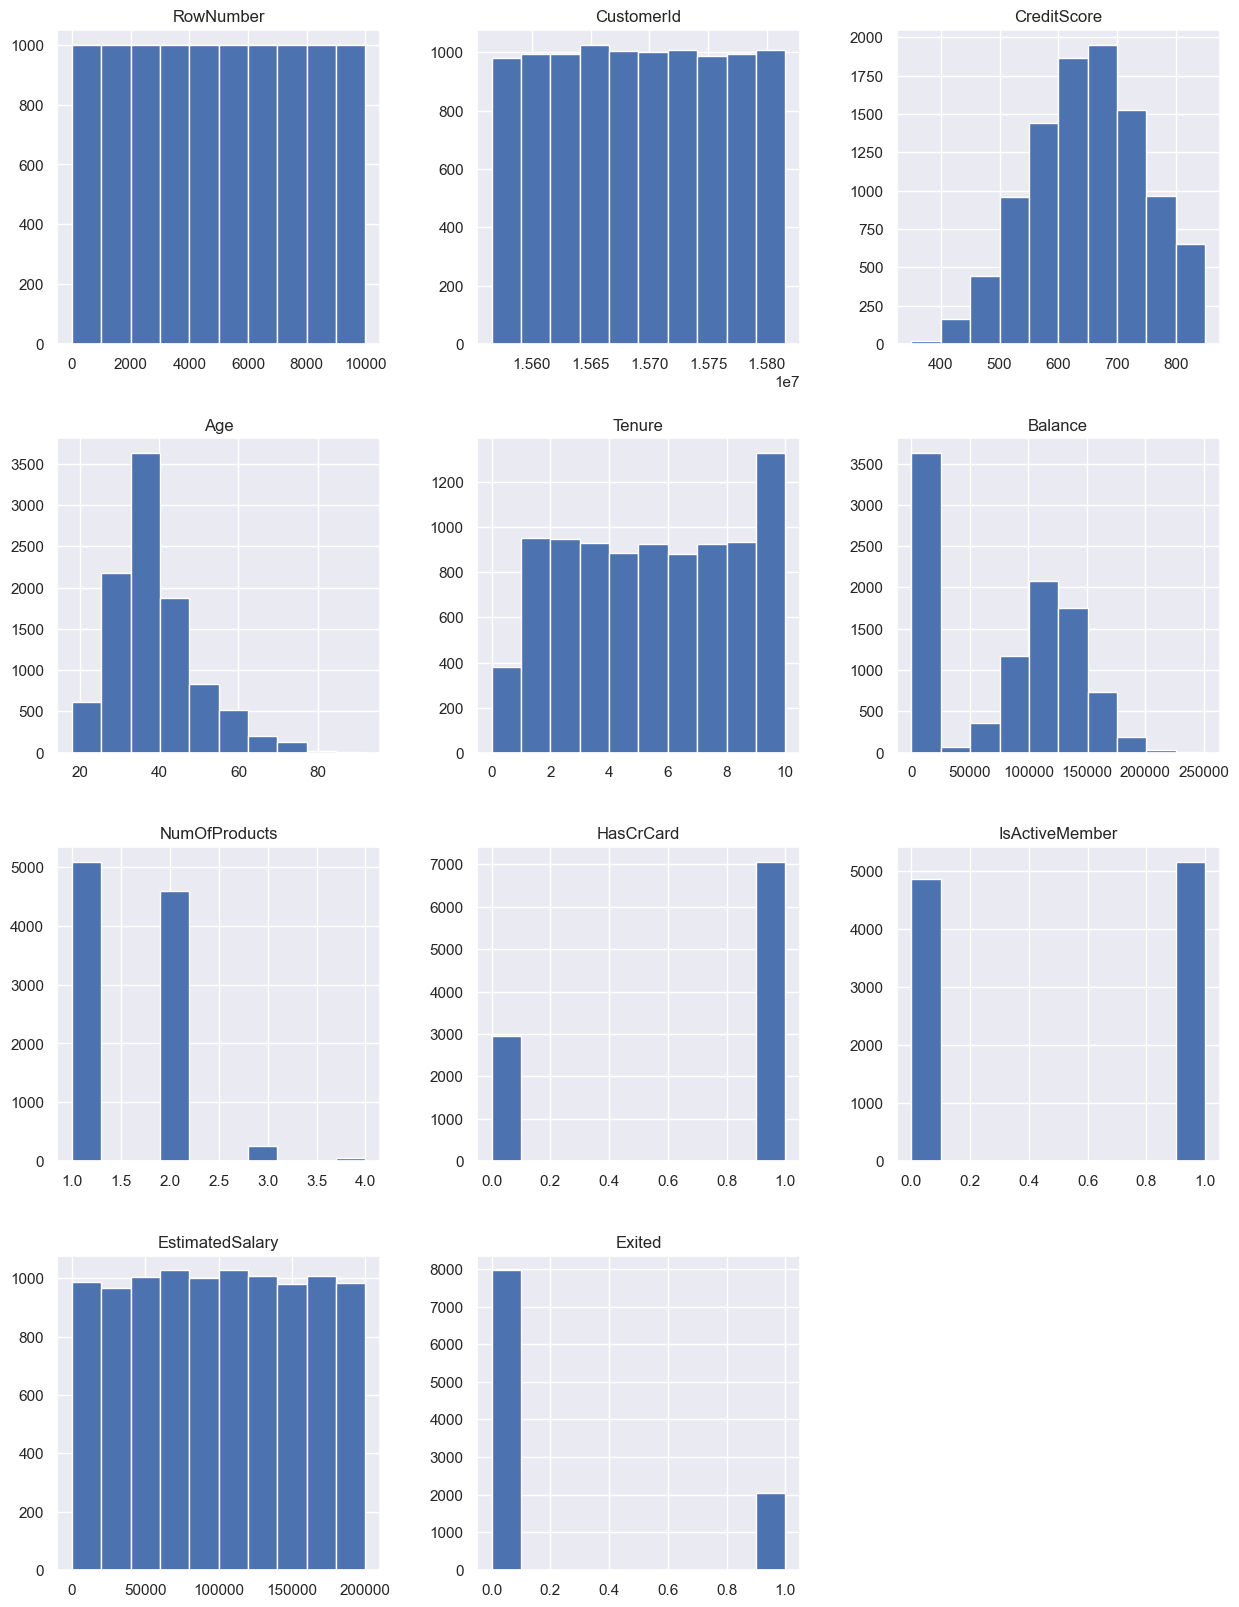

In [6]:
# Setting the style of the plots
sns.set_theme(style="darkgrid")

# Plotting histograms for all numeric columns
clients_data.hist(figsize=(15, 20))
plt.show()

The `RowNumber` and `CustomerID` columns are not of interest to us, unlike the others. We see that the `Credit Score` and `Age` columns have a distribution close to normal, but with some skew. The columns `Tenure`, `Balance` and `EstimatedSalary` have distributions of a different form. The remaining variables have a limited number of values that they can take, which can be seen on the histograms. As for the target variable, we see that approximately 2,000 of the bank's customers have terminated their contracts and left, whilst the remaining 8,000 of them are still considered bank customers. Thus, the classes are unbalanced, which has to be dealt with after data preparation.

## Data preprocessing

Now it is necessary to perform data preprocessing. We don't need to do a large number of conversions: we just need to process the missing values and perform a type conversion in the `Tenure` column, as well as change the column names to those that will be easier to work with. Additionally, we will count the number of explicit duplicates, that is, identical rows.

### Renaming columns

Let's start by changing the column names. In this case, we essentially need to put underscores between individual words (distinguishable by the uppercase letter) in the column names, and then make all uppercase letters lowercase. Here we can proceed, for example, in two ways:

1. On the one hand, we can do this directly: we can pass to the `columns` parameter of the `rename()` function a dictionary with old names (keys) and new names (values) as an argument. This is a working method, but filling in such a dictionary manually will take some time (we will need to manually type in 14 keys and 14 values). 

2. On the other hand, it is possible to use the functionality of regular expressions from the `re` library.

In [7]:
# Changing column names using regular expressions
clients_data = clients_data.rename(
    columns=lambda col_name: re.sub("(?<=[a-z])(?=[A-Z])", "_", col_name).lower()
)

Let's explain exactly how we replaced the column names. Firstly, using the `rename()` function, we pass to its `columns` parameter not a dictionary, but an anonymous lambda function, which essentially returns the result of performing some operation on the column names of the `clients_data` DataFrame. We change the column name using the `sub()` function from the regular expressions library `re`. The function takes in 3 parameters: 

* Certain pattern to be found inside the row (in this case, the row is the name of the column);
* What we need to replace a certain place in the row with; 
* The row itself where we need to look for matches. 

The last two arguments are clear, but let's explain how we made up the pattern. As mentioned before, we need to put underscores before each capital letter (except for the capital letter at the beginning of the column name). This is exactly what is done by the pattern `"(?<=[a-z])(?=[A-Z])"`, which finds all the places in the string between any lowercase letter and any subsequent uppercase letter. The function then places underscores in such places. Finally, we convert the column name to lowercase to get the result. 

Let's see if it was possible to correctly replace the column names by displaying the last five rows of the DataFrame.

In [8]:
display(clients_data.tail())

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


### Missing values

Let's look at the missing values. To do this, let's write a function called `identify_missing_values` which will count the number and proportion of missing values in those columns where there are `NaN` values present.

In [9]:
def identify_missing_values(data):
    """Performs missing values computation.

    Function computes a number and share of missing values
    in DataFrame columns which have NaN-values present
    and displays data types of such columns.

    Parameters
    ----------
    data : DataFrame
        DataFrame which needs to be checked for missing values.

    Returns
    -------
    DataFrame or None
        DataFrame with column names/their data types, number of
        missing values and shares of NaN-values in such columns,
        or None if no missing values have been found.
    """
    # Verifying the presence of missing values
    miss_vals_num = data.isnull().sum()[data.isnull().sum() > 0]
    if miss_vals_num.empty:
        return None

    # Creating a table with numbers of missing values
    cols = {"missing_count": miss_vals_num.values}
    nans_df = pd.DataFrame(data=cols, index=miss_vals_num.index).sort_values(
        by="missing_count", ascending=False
    )

    # Adding shares of missing values
    nans_df["missing_fraction"] = nans_df["missing_count"] / data.shape[0]
    nans_df["missing_fraction"] = nans_df["missing_fraction"].round(4)

    # Adding data types
    nans_df["dtype"] = data[nans_df.index].dtypes
    nans_df = nans_df[["dtype", "missing_count", "missing_fraction"]]

    return nans_df

In [10]:
# Computing the number and share of missing values
nans_df = identify_missing_values(data=clients_data)
display(nans_df)

,dtype,missing_count,missing_fraction
tenure,float64,909,0.0909


As we saw earlier, we have missing values in only one column - `tenure`. The omissions account for only 9% of the data, so we will delete such rows with missing values to save time.

In [11]:
# Deleting rows with NaN-values (share < 10%)
clients_data = clients_data.dropna(
    subset=nans_df[nans_df["missing_fraction"] < 0.1].index
).reset_index(drop=True)

In [12]:
# Verification of all missing values deletion
identify_missing_values(data=clients_data)

As we can see, we have managed to deal with all missing values.

### Data type conversions

Let's consider the general information about the data again.

In [13]:
clients_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        9091 non-null   int64  
 1   customer_id       9091 non-null   int64  
 2   surname           9091 non-null   object 
 3   credit_score      9091 non-null   int64  
 4   geography         9091 non-null   object 
 5   gender            9091 non-null   object 
 6   age               9091 non-null   int64  
 7   tenure            9091 non-null   float64
 8   balance           9091 non-null   float64
 9   num_of_products   9091 non-null   int64  
 10  has_cr_card       9091 non-null   int64  
 11  is_active_member  9091 non-null   int64  
 12  estimated_salary  9091 non-null   float64
 13  exited            9091 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 994.5+ KB


We see that only `tenure` column requires data type conversion. Hence, let's convert its type to `int64`. 

In [14]:
# Conversion to int64
clients_data["tenure"] = clients_data["tenure"].astype("int64")
display(clients_data["tenure"])

0        2
1        1
2        8
3        1
4        2
        ..
9086     2
9087     5
9088    10
9089     7
9090     3
Name: tenure, Length: 9091, dtype: int64

We see that data type has been successfully converted.

### Identical rows

Lastly, let's check if the DataFrame has identical rows and if it does, we will delete them.

In [15]:
def preprocess_duplicates(data):
    """Deletes duplicates from a DataFrame."""
    # Computing the number of duplicates in DataFrame
    num_duplicates = data.duplicated().sum()
    # Checking the number of duplicates for nullity
    if num_duplicates != 0:
        # Deleting duplicates
        data.drop_duplicates(inplace=True)
        # Displaying a message attesting the deletion
        print(f"{num_duplicates:,} duplicates found and deleted.")
        return None
    return None

In [16]:
# Verification of identical rows being present
preprocess_duplicates(data=clients_data)

## Data splitting

Now that we have preprocessed the data, we can move on to preparing the data for machine learning algorithms. To begin with, we will delete the columns that we will not need during the training of models. In this case, these are the columns `row_number`, `customer_id` and `surname`, since they will not carry any relevance regarding the client's choice to stay or terminate the contract with the bank. The first two columns contain purely technical information, and the client's last name cannot in any way influence the client's decision to churn from the bank.

In [17]:
# Deleting irrelevant columns
clients_data = clients_data[clients_data.columns[3:]]
clients_data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


After that we see that we now have all the information that will help us to use classification algorithms. Before splitting the data, let's separate features from target.

In [18]:
# Retrieving features
features = clients_data.drop(["exited"], axis=1)

# Singling out a target vector
target = clients_data["exited"]

Now, we can use `train_test_split` to separate the data into training and test sets.

In [19]:
# Splitting data into training and test sets
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=TEST_SET_SHARE,
    stratify=target,
    random_state=RANDOM_STATE,
)

By passing `target` as argument to `stratify` we make sure that the proportions of the classes in `target` will be preserved in the splits. Let's manually verify that fact.

In [20]:
# Shares of classes in full target
target.value_counts(normalize=True)

0    0.796062
1    0.203938
Name: exited, dtype: float64

In [21]:
# Shares of classes in training target
target_train.value_counts(normalize=True)

0    0.796128
1    0.203872
Name: exited, dtype: float64

In [22]:
# Shares of classes in testing target
target_test.value_counts(normalize=True)

0    0.795864
1    0.204136
Name: exited, dtype: float64

Hence, we see that the class proportions are preserved across sets. Lastly, let's check if the data was split according to the correct proportions.

In [23]:
# Computing shares of training features and training target
features_train_share = np.round(features_train.shape[0] / clients_data.shape[0], 2)
target_train_share = np.round(target_train.shape[0] / clients_data.shape[0], 2)

# Computing shares of testing features and testing target
features_test_share = np.round(features_test.shape[0] / clients_data.shape[0], 2)
target_test_share = np.round(target_test.shape[0] / clients_data.shape[0], 2)

# Verifying the consistency of set shares
assert features_train_share == target_train_share == TRAIN_SET_SHARE
assert features_test_share == target_test_share == TEST_SET_SHARE

## Preprocessing pipelines

In this section, we will define some pipelines for conducting data preprocessing during models training. Firstly, we need to define which columns of the DataFrame will be transformed and how.

We will start with the categorical columns.

In [24]:
# Choosing categorical columns to encode ("object" type)
cat_cols_to_encode = features_train.select_dtypes(include="object").columns.to_list()
print(f"Categorical columns to encode: {cat_cols_to_encode}")

Categorical columns to encode: ['geography', 'gender']


There are only two columns of `object` data type that will need to be encoded. Next, let's consider which numeric columns we will scale. We will make the assumption that numeric features that have less than 5 categories will not require feature scaling and will therefore be left intact.

In [25]:
# Selecting columns with data type other than "object"
num_cols = features_train.select_dtypes(exclude="object").columns.to_list()

# Separating columns into appropriate groups
num_cols_to_scale = []
num_cols_intact = []
for col in num_cols:
    if len(features_train[col].unique()) < 5:
        num_cols_intact.append(col)
    else:
        num_cols_to_scale.append(col)

# Displaying the result
print(f"Numeric columns to scale: {num_cols_to_scale}")
print(f"Numeric columns intact: {num_cols_intact}")

Numeric columns to scale: ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']
Numeric columns intact: ['num_of_products', 'has_cr_card', 'is_active_member']


We can now get to defining the preprocessing pipelines. Firstly, we create a specific pipeline for each kind of features:

* `num_transformer` => Pipeline for numeric columns;
* `one_hot_transformer` => Pipeline for categorical columns;
* `ordinal_transformer` => Pipeline for categorical columns (tree-based models).

In [26]:
# Instantiating SimpleImputer for numeric columns
simple_imputer_num = SimpleImputer(strategy="median")

# Instantiating StandardScaler
scaler = StandardScaler()

# Creating a pipeline for numeric columns
num_transformer = make_pipeline(simple_imputer_num, scaler)

Pipeline for numeric columns consists of two steps:

1. `SimpleImputer(strategy="median")` => Missing values imputer where such values are filled in with median;
2. `StandardScaler` => Features scaler.

In [27]:
# Instantiating SimpleImputer for categorical columnss
simple_imputer_cat = SimpleImputer(strategy="most_frequent")

# Instantiating OneHotEncoder
one_hot_encoder = OneHotEncoder(drop="first", handle_unknown="ignore")

# Creating a pipeline for categorical columns
one_hot_transformer = make_pipeline(simple_imputer_cat, one_hot_encoder)

Categorical columns pipeline is characterized by the following steps:

1. `SimpleImputer(strategy="most_frequent")` => Missing values imputer where such values in categorical columns are replaced with the most frequently met value;
2. `OneHotEncoder(drop="first", handle_unknown="ignore")` => Encoder of categorical features by *One-Hot Encoding* method where we drop the first category to avoid multicollinearity and choose to ignore unknown categories if, for instance, some value is present in test set but not in the training one.

In [28]:
# Instantiating OrdinalEncoder
ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

# Creating a pipeline for categorical columns (tree-based models)
ordinal_transformer = make_pipeline(simple_imputer_cat, ordinal_encoder)

Here, we define another pipeline for tree-based models, since in case encoding categorical features via *One-Hot Encoding* in tree-based models (*Decision Tree* and *Random Forest*), we will have a huge amount of such features and as a result it will take much longer for a model to find an optimal split. Hence, in this case we have introduced *Ordinal Encoding* which should speed up the work of tree-based algorithms.

This pipeline will also make use of the imputer for categorical features but also will have `OrdinalEncoder` as the underlying estimator, rather than `OneHotEncoder`.

Finally, we will combine these pipelines together in the appropriate way:

* `preprocessor_all` => Preprocessor for any model with numeric features scaling and *One-Hot encoding*;
* `preprocessor_tree` => Preprocessor for tree-based models with numeric features scaling and *Ordinal Encoding*.

In [29]:
# Chaining pipelines (all models)
preprocessor_all = make_column_transformer(
    (num_transformer, num_cols_to_scale),
    (one_hot_transformer, cat_cols_to_encode),
    remainder="passthrough",
    verbose_feature_names_out=False,
)

# Chaining pipelines (tree-based models)
preprocessor_tree = make_column_transformer(
    (num_transformer, num_cols_to_scale),
    (ordinal_transformer, cat_cols_to_encode),
    remainder="passthrough",
    verbose_feature_names_out=False,
)

Notably, we have left some columns intact by setting `remainder="passthrough"` for columns with already encoded categories which do not really need any operations performed on them.

**Conclusion**

At this stage, the data was carefully studied and a few problems were identified (missing values, incorrect data type and incorrect column names), which were corrected as a result of data preprocessing. Furthermore, the data was brought to the proper form by applying data partitioning into training and test sets. We have also prepared appropriate preprocessing pipelines that will be useful later when training machine learning models.

# Classes balance analysis

Now let's move on to studying the class balance. To do this, we will build a bar chart, where we will indicate what percentage of the observations in the target variable for the training set belongs to each class. We are interested in the training set, because it is important to us to understand whether the algorithms will learn from balanced or unbalanced data.

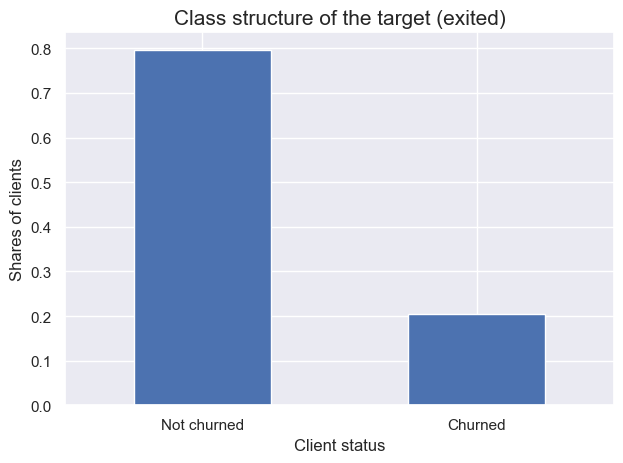

In [30]:
# Plotting a histogram for a target
target_train.value_counts(normalize=True).plot(
    kind="bar",
    xlabel="Client status",
    ylabel="Shares of clients",
)
plt.xticks(ticks=[0, 1], labels=["Not churned", "Churned"], rotation=0)
plt.title("Class structure of the target (exited)", fontsize=15)
plt.tight_layout()
plt.show()

We can see that approximately 80% of all objects are accounted for by those who stayed with the bank (class "0"), while the remaining 20% are gone. Thus, we are dealing with an unbalanced classification, in which models usually show poor learning performance.

# Setting class weights

In this section, we will consider models provided that the class imbalance is either ignored or accounted for by `class_weight` hyperparameter. We will thus include this hyperparameter in the parameter grid which will help us understand whether applying class weighting stategy is conducive to improvements in models predictive performance. 

We will conduct a series of hyperparameter tunings for the following three classification models:

* *Decision Tree Classifier*
* *Random Forest Classifier*
* *Logistic Regression*

We will focus on the value of the *F1* metric on the validation set.

## Decision Tree

In [31]:
# Defining a Decision Tree model
dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Joining the preprocessor for tree-based models with DTC
dt_pipeline = make_pipeline(preprocessor_tree, dt_model)

In [32]:
%%time

# Setting a hyperparameter grid
dt_params_grid = {
    "decisiontreeclassifier__max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, None],
    "decisiontreeclassifier__criterion": ["gini", "entropy", "log_loss"],
    "decisiontreeclassifier__class_weight": [None, "balanced"],
}

# Instantiating RSCV object
dt_grid_search = RandomizedSearchCV(
    estimator=dt_pipeline,
    param_distributions=dt_params_grid,
    scoring=SCORER,
    cv=CV_FOLDS,
    n_iter=N_ITER,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

# Launching randomized grid search algorithm 
dt_grid_search.fit(features_train, target_train)

# Displaying the best CV F1-score
print(f"{SCORER.capitalize()} score (Decision Tree): {dt_grid_search.best_score_:.3f}\n")

F1 score (Decision Tree): 0.555

CPU times: total: 1.64 s
Wall time: 7.74 s


In [33]:
# Displaying hyperparameters of the best model
dt_grid_search.best_params_

{'decisiontreeclassifier__max_depth': 5,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__class_weight': 'balanced'}

## Random Forest

In [34]:
# Defining a Random Forest model
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

# Joining pipeline for tree-based models with RFC
rf_pipeline = make_pipeline(preprocessor_tree, rf_model)

In [35]:
%%time

# Setting a hyperparameter grid
rf_params_grid = {
    "randomforestclassifier__max_depth": [1, 2, 3, 4, 5, 6, None],
    "randomforestclassifier__n_estimators": np.arange(10, 210, 10),
    "randomforestclassifier__class_weight": [None, "balanced"],
}

# Instantiating RSCV object
rf_grid_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_params_grid,
    scoring=SCORER,
    cv=CV_FOLDS,
    n_iter=N_ITER,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

# Launching randomized grid search algorithm 
rf_grid_search.fit(features_train, target_train)

# Displaying the best CV F1-score
print(f"{SCORER.capitalize()} score (Random Forest): {rf_grid_search.best_score_:.3f}\n")

F1 score (Random Forest): 0.590

CPU times: total: 5.72 s
Wall time: 1min 21s


In [36]:
# Displaying hyperparameters of the best model
rf_grid_search.best_params_

{'randomforestclassifier__n_estimators': 160,
 'randomforestclassifier__max_depth': 6,
 'randomforestclassifier__class_weight': 'balanced'}

## Logistic Regression

In [37]:
# Defining a Logistic Regression model
lr_model = LogisticRegression(random_state=RANDOM_STATE)

# Joining the pipeline with LR
lr_pipeline = make_pipeline(preprocessor_all, lr_model)

In [38]:
%%time

# Setting a hyperparameter grid
lr_params_grid = {
    "logisticregression__C": stats.loguniform(0.0001, 1000.0),
    "logisticregression__max_iter": [100, 1000, 10000, 100000],
    "logisticregression__class_weight": [None, "balanced"],
}

# Instantiating RSCV object
lr_grid_search = RandomizedSearchCV(
    estimator=lr_pipeline,
    param_distributions=lr_params_grid,
    scoring=SCORER,
    cv=CV_FOLDS,
    n_iter=N_ITER,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

# Launching randomized grid search algorithm 
lr_grid_search.fit(features_train, target_train)

# Displaying the best CV F1-score
print(f"{SCORER.capitalize()} score (Logistic Regression): {lr_grid_search.best_score_:.3f}\n")

F1 score (Logistic Regression): 0.505

CPU times: total: 2.19 s
Wall time: 5.52 s


In [39]:
# Displaying the hyperparameters of the best model
lr_grid_search.best_params_

{'logisticregression__C': 0.003409182936980809,
 'logisticregression__class_weight': 'balanced',
 'logisticregression__max_iter': 100000}

It can be seen that in all subsections grid search algorithm highlighted the importance of `class_weight="balanced"` setting.

## Model comparison

Now, we will combine all results in one data structure which we will plot for choosing the best model within this method of combating class imbalance.

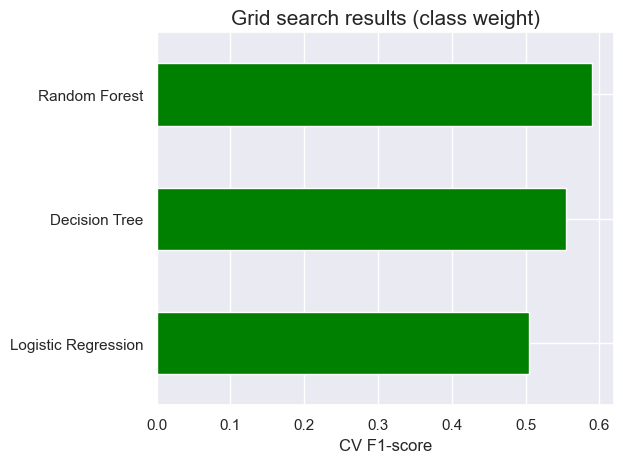

In [40]:
# Combining the results of grid search by model
cv_results_cw = OrderedDict()
cv_results_cw["Decision Tree"] = dt_grid_search.best_score_
cv_results_cw["Random Forest"] = rf_grid_search.best_score_
cv_results_cw["Logistic Regression"] = lr_grid_search.best_score_

# Transforming the dict to Series object
cv_results_cw = pd.Series(cv_results_cw).sort_values()

# Plotting grid search results
cv_results_cw.plot(kind="barh", color="green")
plt.xlabel("CV F1-score")
plt.title("Grid search results (class weight)", fontsize=15)
plt.tight_layout()
plt.show()

So, we see that the best model based on *F1* metric is the model of the Random Forest.

In [41]:
# Choosing the best model inside the grid (class weight)
best_grid_cw = deepcopy(rf_grid_search)

**Conclusion**

In this section, an analysis of the balance of classes was carried out and a series of hyperparameters tunings were carried out for three selected classification models. The fact of the presence of an imbalance in the data was revealed, where it is expressed in proportions of 80-20. As a result of training models, the best model according to the *F1* metric is the model of the Random Forest.

# Upsampling

The next technique we will use is called upsampling, where we increase our sample size with the same data to achieve classes balance. This can be done by making use of `SMOTE` from `over_sampling` module of `imblearn` library for dealing with imbalanced data. In order to be able to use it inside the pipeline we will have to redefine our preprocessors using another specific function which we imported - `make_imb_pipeline` (alias for `make_pipeline` from `imblearn.over_sampling`).

In [42]:
# Creating a pipeline for numeric columns
num_transformer_imb = make_imb_pipeline(simple_imputer_num, scaler)

# Creating a pipeline for categorical columns
one_hot_transformer_imb = make_imb_pipeline(simple_imputer_cat, one_hot_encoder)

# Creating a pipeline for categorical columns (tree-based models)
ordinal_transformer_imb = make_imb_pipeline(simple_imputer_cat, ordinal_encoder)

Firstly, we again chained different estimators again but now using a special function from `imblearn`.

In [43]:
# Chaining pipelines (all models)
preprocessor_all_imb = make_column_transformer(
    (num_transformer_imb, num_cols_to_scale),
    (one_hot_transformer_imb, cat_cols_to_encode),
    remainder="passthrough",
    verbose_feature_names_out=False,
)

# Chaining pipelines (tree-based models)
preprocessor_tree_imb = make_column_transformer(
    (num_transformer_imb, num_cols_to_scale),
    (ordinal_transformer_imb, cat_cols_to_encode),
    remainder="passthrough",
    verbose_feature_names_out=False,
)

Secondly, we define new preprocessors that will now make use of `make_imb_pipeline` function.

In [44]:
# Instantiating SMOTE object
oversampler = SMOTE(random_state=RANDOM_STATE)

Lastly, we simply define `SMOTE` object that we will add to the created preprocessors.

## Decision Tree

In [45]:
# Joining the preprocessor for tree-based models with SMOTE and DTC
dt_pipeline_oversample = make_imb_pipeline(preprocessor_tree_imb, oversampler, dt_model)

In [46]:
%%time

# Setting a hyperparameter grid
dt_params_grid = {
    "decisiontreeclassifier__max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, None],
    "decisiontreeclassifier__criterion": ["gini", "entropy", "log_loss"],
}

# Instantiating RSCV object
dt_grid_search = RandomizedSearchCV(
    estimator=dt_pipeline_oversample,
    param_distributions=dt_params_grid,
    scoring=SCORER,
    cv=CV_FOLDS,
    n_iter=N_ITER,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

# Launching randomized grid search algorithm 
dt_grid_search.fit(features_train, target_train)

# Displaying the best CV F1-score
print(f"{SCORER.capitalize()} score (Decision Tree, upsampling): {dt_grid_search.best_score_:.3f}\n")

F1 score (Decision Tree, upsampling): 0.574

CPU times: total: 3.03 s
Wall time: 14.4 s


In [47]:
# Displaying hyperparameters of the best model
dt_grid_search.best_params_

{'decisiontreeclassifier__max_depth': 8,
 'decisiontreeclassifier__criterion': 'entropy'}

## Random Forest

In [48]:
# Joining the preprocessor for tree-based models with SMOTE and RFC
rf_pipeline_oversample = make_imb_pipeline(preprocessor_tree_imb, oversampler, rf_model)

In [49]:
%%time

# Setting a hyperparameter grid
rf_params_grid = {
    "randomforestclassifier__max_depth": [1, 2, 3, 4, 5, 6, None],
    "randomforestclassifier__n_estimators": np.arange(10, 210, 10),
}

# Instantiating RSCV object
rf_grid_search = RandomizedSearchCV(
    estimator=rf_pipeline_oversample,
    param_distributions=rf_params_grid,
    scoring=SCORER,
    cv=CV_FOLDS,
    n_iter=N_ITER,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

# Launching randomized grid search algorithm 
rf_grid_search.fit(features_train, target_train)

# Displaying the best CV F1-score
print(f"{SCORER.capitalize()} score (Random Forest, upsampling): {rf_grid_search.best_score_:.3f}\n")

F1 score (Random Forest, upsampling): 0.599

CPU times: total: 5.2 s
Wall time: 2min 13s


In [50]:
# Displaying hyperparameters of the best model
rf_grid_search.best_params_

{'randomforestclassifier__n_estimators': 50,
 'randomforestclassifier__max_depth': 6}

## Logistic Regression

In [51]:
# Joining the preprocessor with SMOTE and LR
lr_pipeline_oversample = make_imb_pipeline(preprocessor_all_imb, oversampler, lr_model)

In [52]:
%%time

# Setting a hyperparameter grid
lr_params_grid = {
    "logisticregression__C": stats.loguniform(0.0001, 1000.0),
    "logisticregression__max_iter": [100, 1000, 10000, 100000],
}

# Instantiating RSCV object
lr_grid_search = RandomizedSearchCV(
    estimator=lr_pipeline_oversample,
    param_distributions=lr_params_grid,
    scoring=SCORER,
    cv=CV_FOLDS,
    n_iter=N_ITER,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

# Launching randomized grid search algorithm 
lr_grid_search.fit(features_train, target_train)

# Displaying the best CV F1-score
print(f"{SCORER.capitalize()} score (Logistic Regression, upsampling): {lr_grid_search.best_score_:.3f}\n")

F1 score (Logistic Regression, upsampling): 0.505

CPU times: total: 3.45 s
Wall time: 9.64 s


In [53]:
# Displaying hyperparameters of the best model
lr_grid_search.best_params_

{'logisticregression__C': 0.000822150008909207,
 'logisticregression__max_iter': 1000}

## Model selection

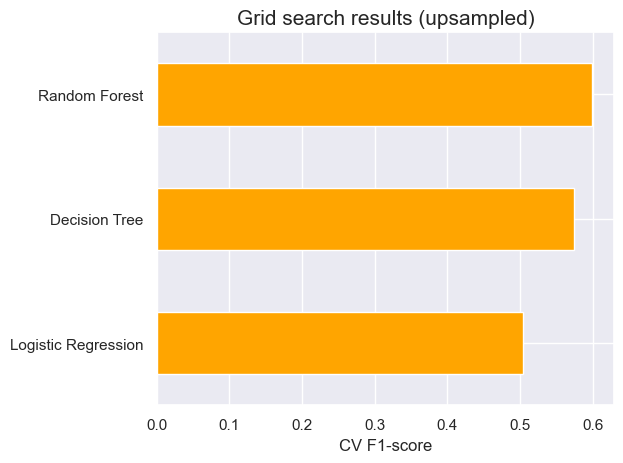

In [54]:
# Combining the results of grid search by model
cv_results_upsample = OrderedDict()
cv_results_upsample["Decision Tree"] = dt_grid_search.best_score_
cv_results_upsample["Random Forest"] = rf_grid_search.best_score_
cv_results_upsample["Logistic Regression"] = lr_grid_search.best_score_

# Transforming the dict to Series object
cv_results_upsample = pd.Series(cv_results_upsample).sort_values()

# Plotting grid search results
cv_results_upsample.plot(kind="barh", color="orange")
plt.xlabel("CV F1-score")
plt.title("Grid search results (upsampled)", fontsize=15)
plt.tight_layout()
plt.show()

In [55]:
# Choosing the best model inside the grid (upsampling)
best_grid_upsample = deepcopy(rf_grid_search)

The best model for the case of upsampling is a Random Forest with 50 trees, each with a depth of 6.

# Downsampling

The last technique we will consider is downsampling, which is the opposite of upsampling: we decrease sample size to achieve class balance. This can also be done using `imblearn` library, where we will make use of `RandomUnderSampler()` from `under_sampling` module.

In [56]:
# Instantiating RandomUnderSampler object
undersampler = RandomUnderSampler(random_state=RANDOM_STATE)

## Decision Tree

In [57]:
# Joining the preprocessor for tree-based models with RandomUnderSampler and DTC
dt_pipeline_undersample = make_imb_pipeline(
    preprocessor_tree_imb, undersampler, dt_model
)

In [58]:
%%time

# Setting a hyperparameter grid
dt_params_grid = {
    "decisiontreeclassifier__max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, None],
    "decisiontreeclassifier__criterion": ["gini", "entropy", "log_loss"],
}

# Instantiating RSCV object
dt_grid_search = RandomizedSearchCV(
    estimator=dt_pipeline_undersample,
    param_distributions=dt_params_grid,
    scoring=SCORER,
    cv=CV_FOLDS,
    n_iter=N_ITER,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

# Launching randomized grid search algorithm 
dt_grid_search.fit(features_train, target_train)

# Displaying the best CV F1-score
print(f"{SCORER.capitalize()} score (Decision Tree, undersampling): {dt_grid_search.best_score_:.3f}\n")

F1 score (Decision Tree, undersampling): 0.548

CPU times: total: 2.45 s
Wall time: 5.53 s


In [59]:
# Displaying hyperparameters of the best model
dt_grid_search.best_params_

{'decisiontreeclassifier__max_depth': 6,
 'decisiontreeclassifier__criterion': 'entropy'}

## Random Forest

In [60]:
# Joining the preprocessor for tree-based models with RandomUnderSampler and RFC
rf_pipeline_undersample = make_imb_pipeline(
    preprocessor_tree_imb, undersampler, rf_model
)

In [61]:
%%time

# Setting a hyperparameter grid
rf_params_grid = {
    "randomforestclassifier__max_depth": [1, 2, 3, 4, 5, 6, None],
    "randomforestclassifier__n_estimators": np.arange(10, 210, 10),
}

# Instantiating RSCV object
rf_grid_search = RandomizedSearchCV(
    estimator=rf_pipeline_undersample,
    param_distributions=rf_params_grid,
    scoring=SCORER,
    cv=CV_FOLDS,
    n_iter=N_ITER,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

# Launching randomized grid search algorithm 
rf_grid_search.fit(features_train, target_train)

# Displaying the best CV F1-score
print(f"{SCORER.capitalize()} score (Random Forest, undersampling): {rf_grid_search.best_score_:.3f}\n")

F1 score (Random Forest, undersampling): 0.587

CPU times: total: 3.91 s
Wall time: 44.5 s


In [62]:
# Displaying hyperparameters of the best model
rf_grid_search.best_params_

{'randomforestclassifier__n_estimators': 90,
 'randomforestclassifier__max_depth': 6}

## Logistic Regression

In [63]:
# Joining the preprocessor with RandomUnderSampler and LR
lr_pipeline_undersample = make_imb_pipeline(
    preprocessor_all_imb, undersampler, lr_model
)

In [64]:
%%time

# Setting a hyperparameter grid
lr_params_grid = {
    "logisticregression__C": stats.loguniform(0.0001, 1000.0),
    "logisticregression__max_iter": [100, 1000, 10000, 100000],
}

# Instantiating RSCV object
lr_grid_search = RandomizedSearchCV(
    estimator=lr_pipeline_undersample,
    param_distributions=lr_params_grid,
    scoring=SCORER,
    cv=CV_FOLDS,
    n_iter=N_ITER,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

# Launching randomized grid search algorithm 
lr_grid_search.fit(features_train, target_train)

# Displaying the best CV F1-score
print(f"{SCORER.capitalize()} score (Logistic Regression, upsampling): {lr_grid_search.best_score_:.3f}\n")

F1 score (Logistic Regression, upsampling): 0.508

CPU times: total: 2.56 s
Wall time: 5.26 s


In [65]:
# Displaying hyperparameters of the best model
lr_grid_search.best_params_

{'logisticregression__C': 0.002703472460317347,
 'logisticregression__max_iter': 1000}

## Model selection

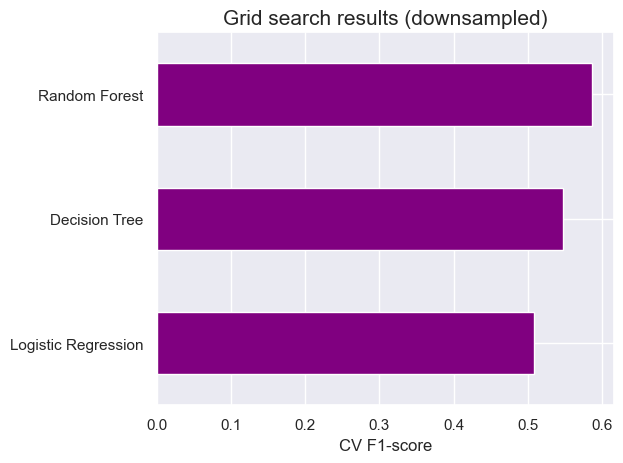

In [66]:
# Combining the results of grid search by model
cv_results_downsample = OrderedDict()
cv_results_downsample["Decision Tree"] = dt_grid_search.best_score_
cv_results_downsample["Random Forest"] = rf_grid_search.best_score_
cv_results_downsample["Logistic Regression"] = lr_grid_search.best_score_

# Transforming the dict to Series object
cv_results_downsample = pd.Series(cv_results_downsample).sort_values()

# Plotting grid search results
cv_results_downsample.plot(kind="barh", color="purple")
plt.xlabel("CV F1-score")
plt.title("Grid search results (downsampled)", fontsize=15)
plt.tight_layout()
plt.show()

In [67]:
# Choosing the best model inside the grid (upsampling)
best_grid_downsample = deepcopy(rf_grid_search)

The best model here is again a Random Forest with 90 trees and a depth of 6.

# Final comparison

Now we are ready to compare the models. Let's create a table that will show which model we will end up testing.

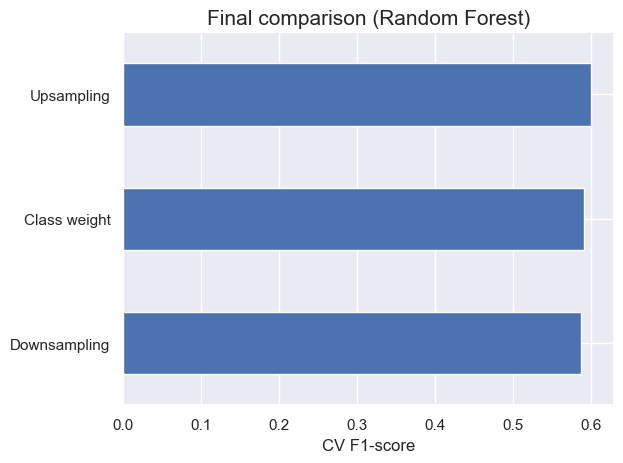

In [68]:
# Combining the results of grid search by model
cv_results_final = OrderedDict()
cv_results_final["Class weight"] = best_grid_cw.best_score_
cv_results_final["Upsampling"] = best_grid_upsample.best_score_
cv_results_final["Downsampling"] = best_grid_downsample.best_score_

# Transforming the dict to Series object
cv_results_final = pd.Series(cv_results_final).sort_values()

# Plotting grid search results
cv_results_final.plot(kind="barh")
plt.xlabel("CV F1-score")
plt.title("Final comparison (Random Forest)", fontsize=15)
plt.tight_layout()
plt.show()

We see that the best model which outperforms others in terms of *F1* metric computed on the validation set proves to be a Random Forest model with 60 trees and a depth of 9 that resulted from applying upsampling method.

In [69]:
# Retrieving the best model (the most optimal one)
best_model = best_grid_upsample.best_estimator_

In [70]:
# Displaying the best hyperparameter values
best_model_params = best_grid_upsample.best_params_
print(best_model_params)

{'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__max_depth': 6}


**Conclusion**

This short section showcased the model which we will eventually use for testing. The most preferrable method in our case is upsampling method.

# Testing 

Lastly, let's test the model and determine whether it passed all tests we have predefined.

In [71]:
# Testing the best model
predictions_test = best_model.predict(features_test)
f1_test = f1_score(y_true=target_test, y_pred=predictions_test)
print(f"Test F1-Score: {f1_test:.3f}")

# Computing AUC-ROC
class_probs = best_model.predict_proba(features_test)
pos_class_probs = class_probs[:, 1]
auc_roc_test = roc_auc_score(y_true=target_test, y_score=pos_class_probs)
print(f"Test AUC-ROC: {auc_roc_test:.3f}")

Test F1-Score: 0.618
Test AUC-ROC: 0.863


Now we will train a dummy model which will always predict a positive class so in this case the model will classify all clients as those who will churn. After training we will compute its *F1-score*.

In [72]:
# Instantiating a dummy model
dummy_model = DummyClassifier(strategy="constant", constant=1)

# Training a dummy model
dummy_model.fit(features_train, target_train)

# Computing dummy predictions
dummy_predictions = dummy_model.predict(features_test)

# Computing F1-score on test set
f1_test_dummy = f1_score(y_true=target_test, y_pred=dummy_predictions)

We can now run some checks on whether:

* The model satisfies the minimal requirements of *F1-score*;
* The model is adequate and thus surpasses a dummy model;
* The model is better than a random one.

In [73]:
# Verifying model performance
assert (
    f1_test >= F1_SCORE_THRESHOLD
), f"Value of test F1 score is less than {F1_SCORE_THRESHOLD}"

# Sanity check #1
assert f1_test > f1_test_dummy, f"Model is inadequate"

# Sanity check #2
assert (
    auc_roc_test > AUC_ROC_THRESHOLD
), f"Value of test AUC_ROC score is less than {AUC_ROC_THRESHOLD}"

# Summarizing the results in case the model passed the tests
recall_test = recall_score(y_true=target_test, y_pred=predictions_test)
precision_test = precision_score(y_true=target_test, y_pred=predictions_test)

print(
    f"Recall: \nThe model correctly detects that {recall_test:.1%} of churned clients - churned ones.\n"
)
print(
    f"Precision: \nThe model correctly detects that {precision_test:.1%} of clients - churned ones."
)

Recall: 
The model correctly detects that 69.0% of churned clients - churned ones.

Precision: 
The model correctly detects that 56.0% of clients - churned ones.


# Final model analysis

## Feature importances

`RandomForestClassifier` enables us to compute importances scores that each feature seen during training contributes to the final predictions. Using a random forest, we can measure the feature importance as the averaged impurity decrease computed from all decision trees in the forest, without making any assumptions about whether our data is linearly separable or not.

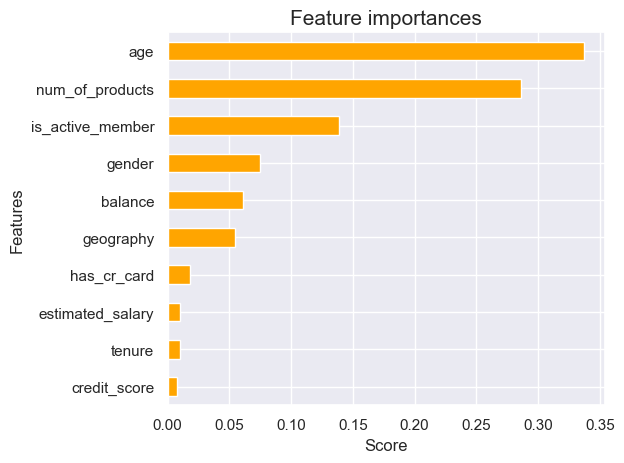

In [74]:
# Retrieving feature importance scores with feature names
feature_importances = pd.Series(
    best_model["randomforestclassifier"].feature_importances_,
    index=best_model["columntransformer"].get_feature_names_out(),
).sort_values()

# Plotting feature importances
feature_importances.plot(kind="barh", color="orange")

plt.xlabel("Score")
plt.ylabel("Features")
plt.title("Feature importances", fontsize=15)
plt.tight_layout()
plt.show()

It turns out that `age`, `num_of_products` and `is_active_member` prove to be the most important features that affect the client's decision to churn.

## Classification metrics

More of classification metrics can be computed via `classification_report` function.

In [75]:
# Names of classes to be printed in the report
target_names = ["Unchurned", "Churned"]

# Printing the classification metrics table
print(
    classification_report(
        y_true=target_test, y_pred=predictions_test, target_names=target_names
    )
)

              precision    recall  f1-score   support

   Unchurned       0.92      0.86      0.89      1809
     Churned       0.56      0.69      0.62       464

    accuracy                           0.83      2273
   macro avg       0.74      0.78      0.75      2273
weighted avg       0.84      0.83      0.83      2273



We can see that we get the same values of precision, recall and F1 scores that we obtained in the previous section.

## ROC Curve/PR Curve

In this section we will plot two kinds of classification curves:

* ROC Curve;
* Precision-Recall Curve (PR Curve).

In [76]:
# Computing False Positive Rates (FPR) and True Positive Rates (TPR)
fpr, tpr, _ = roc_curve(y_true=target_test, y_score=pos_class_probs)

# Computing AUC for ROC
roc_auc = auc(x=fpr, y=tpr)

# Instantiating RCD object
roc_curve_display = RocCurveDisplay(
    fpr=fpr,
    tpr=tpr,
    pos_label=best_model.classes_[1],
    roc_auc=roc_auc,
    estimator_name="Random Forest",
)

In [77]:
# Computing precision and recall scores
precision, recall, _ = precision_recall_curve(
    y_true=target_test, probas_pred=pos_class_probs
)

# Computing average precision score
average_precision = average_precision_score(y_true=target_test, y_score=pos_class_probs)

# Computing positive label prevalence
prevalence_pos_label = Counter(target_test.ravel())[1] / target_test.size

# Computing average
pr_curve_display = PrecisionRecallDisplay(
    precision=precision,
    recall=recall,
    pos_label=best_model.classes_[1],
    average_precision=average_precision,
    prevalence_pos_label=prevalence_pos_label,
    estimator_name="Random Forest",
)

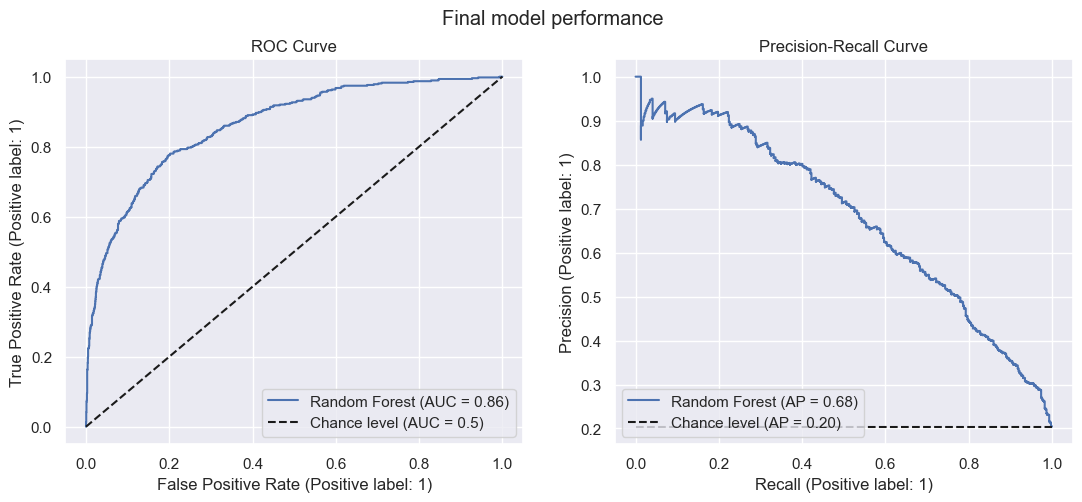

In [78]:
# Plotting AUC-ROC and PR Curves as subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

roc_curve_display.plot(ax=ax1, plot_chance_level=True)
pr_curve_display.plot(ax=ax2, plot_chance_level=True)

ax1.set_title("ROC Curve")
ax2.set_title("Precision-Recall Curve")
plt.suptitle("Final model performance")
plt.show()

## Confusion matrix

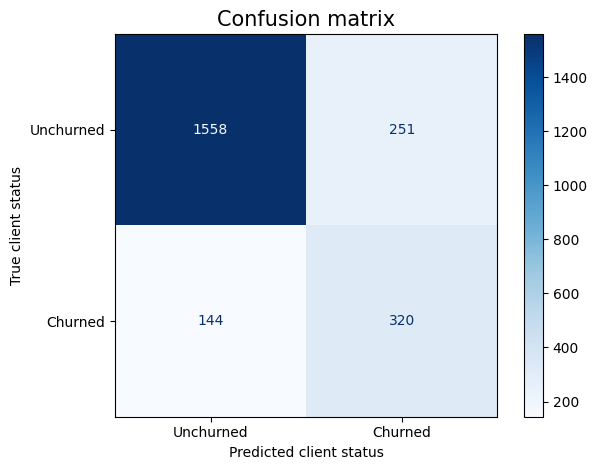

In [79]:
# Plotting confusion matrix
sns.reset_defaults()

# Computing a confusion matrix
cm = confusion_matrix(
    y_true=target_test, y_pred=predictions_test, labels=best_model.classes_
)

# Instantiating CMD object
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=target_names,
)

# Plotting a confusion matrix
cm_display.plot(cmap="Blues")

plt.xlabel("Predicted client status")
plt.ylabel("True client status")
plt.title(f"Confusion matrix", fontsize=15)
plt.tight_layout()
plt.show()

In [80]:
# Saving the final model in a file
dump(best_model, "churn_pred_model.joblib")

['churn_pred_model.joblib']

# Predicting new data

We can now use the trained model for predicting some new unseen data. Firstly, load the saved model.

In [81]:
# Loading the trained model
model = load("churn_pred_model.joblib")

Now, let's come up with some potential bank clients with the following features.

In [82]:
# Defining new data for classification
new_data = pd.DataFrame(
    data={
        "credit_score": 800,
        "geography": "Germany",
        "gender": "Male",
        "age": 28,
        "tenure": 2,
        "balance": 54036,
        "num_of_products": 2,
        "has_cr_card": 1,
        "is_active_member": 0,
        "estimated_salary": 20000,
    },
    index=[0],
)

display(new_data)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
0,800,Germany,Male,28,2,54036,2,1,0,20000


We can use the model to generate a prediction about this client.

In [83]:
# Predicting class and its probability
new_data_prediction = model.predict(new_data)[0]
new_data_prediction_prob = model.predict_proba(new_data)

# Displaying prediction
if new_data_prediction == 0:
    print("Client is predicted to not to churn.")
else:
    print("Client is predicted to churn.")

print(f"Probability: {new_data_prediction_prob[0][new_data_prediction]:.1%}")

Client is predicted to not to churn.
Probability: 82.3%


# General conclusion

In this study, the data of "Beta Bank" customers were analyzed and an optimal model for predicting the clients churn from the bank was selected, which takes into account the features of the data, the most striking of which is the revealed fact of the presence of an imbalance of classes. The data has been thoroughly analyzed, preprocessed and prepared for their use in machine learning algorithms. 

The main part of the study consisted in carrying out several series of hyperparameter selections for the case of ignoring the imbalance and three cases of dealing with class imbalance, which include weighing classes, upsampling and downsampling. According to the results of the study, the final model, which was chosen at the final stage, is a Random Forest with 50 trees, where each of them has a depth of 6. It is worth mentioning that it was the method of upsampling that allowed us to obtain such results. In the test set, the model showed values of the metric *F1* at about 0.62, which is higher than the set threshold of 0.59. The model differs from the random one, which is manifested in a rather high value of the metric *AUC-ROC*.